# Novel Methods to Identify Bivariate Relationships
In this notebook, we explore various methods to identify some relationships within the data collected from the first and second UTx000 cohorts.  

In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
# general
import os
import sys
sys.path.append('../')
# user-defined functions
from src.visualization import visualize
# basic data science
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
from minepy import MINE
from sklearn import linear_model
# timeseries
from datetime import datetime, timedelta
# plottings
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

# Table of Contents
1. [Helper Functions](#functions)
3. [Maximal Information Coefficient](#mic)

<a id="functions"></a>

# Helper Functions
Functions used throughout the analysis

In [3]:
def plot_scatter(df,xlabel,ylabel,square=True):
    """plots the scatter of the two parameters p1 and p2"""
    _, ax= plt.subplots(figsize=(6,6))
    sns.scatterplot(xlabel,ylabel,data=df,
                    s=25,color="black",alpha=0.5,ax=ax)
    # min and max value
    if square:
        min_val = min(df[xlabel]) if min(df[xlabel]) < min(df[ylabel]) else min(df[ylabel])
        max_val = max(df[xlabel]) if max(df[xlabel]) > max(df[ylabel]) else max(df[ylabel])
        ax.set_xlim([min_val,max_val])
        ax.set_ylim([min_val,max_val])
    ax.set_xlabel(xlabel,fontsize=14)
    ax.set_ylabel(ylabel,fontsize=14)
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    plt.show()
    plt.close()

In [4]:
def get_pt_data(df,pt,by_id="beiwe"):
    """gets df just for the given participant"""
    return df[df[by_id] == pt]

In [5]:
def filter_df(df,param,val,gt=True):
    """filters a dataframe for param values gt (or lt) a provided val"""
    if gt:
        return df[df[param] > val]
    else:
        return df[df[param] < val]

In [6]:
def compute_linear_regression(df,xlabel,ylabel,**kwargs):
    """computes the linear regression and returns the x0, x1, and r2"""
    x = df.loc[:,xlabel].values
    y = df.loc[:,ylabel].values

    regr = linear_model.LinearRegression()
    try:
        if "weights" in kwargs.keys():
            weights = kwargs["weights"]
        else:
            weights= None
        regr.fit(x.reshape(-1, 1), y, sample_weight=weights)
        return regr.intercept_, regr.coef_[0], regr.score(x.reshape(-1, 1),y)
    except ValueError as e:
        print(f"Error with data ({e}) - returning (0,1)")
        return 0, 1, 0

<a id="mic"></a>

# MIC
Maximal Information Coefficient

In [7]:
def get_mic(df,xlabel,ylabel):
    """gets the MIC score between the two variables"""
    x = df[xlabel].values
    y = df[ylabel].values
    
    mine = MINE(alpha=0.6, c=15, est="mic_approx")
    mine.compute_score(x,y)
    score = mine.mic()
    
    return score

## Self-Report TST vs Fitbit TST
One of the more straightforward relationships that we can analyze.

### Data Import and Visualization
Getting the data in, combined, and taking an initial look at it.

In [8]:
# fitbit data
fb = pd.read_csv("../data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["end_date"],infer_datetime_format=True)
# beiwe data - adding date column to merge
bw = pd.read_csv("../data/processed/beiwe-morning_ema-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
bw["end_date"] = pd.to_datetime(bw["timestamp"].dt.date)
# merging and getting relevant data only
merged = bw.merge(fb,on=["beiwe","end_date"])
tst_df = merged[["beiwe","tst","tst_fb"]]

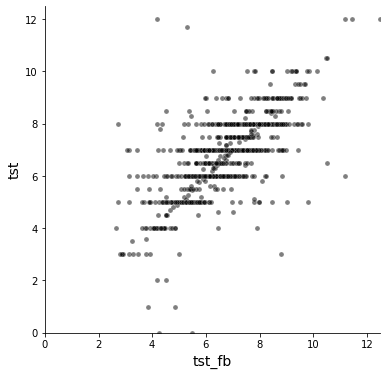

In [9]:
plot_scatter(tst_df,"tst_fb","tst")

### Analyzing with MIC

In [10]:
mic_score_tst = get_mic(tst_df,"tst_fb","tst")
_,_,r2_tst = compute_linear_regression(tst_df.dropna(),"tst_fb","tst")
print(f"MIC:\t{round(mic_score_tst,4)}\nOLS:\t{round(r2_tst,4)}")

MIC:	0.3696
OLS:	0.4952


<div class="alert alert-block alert-warning">
 
MIC was able to see some sort of relationship, but not as well as OLS. MIC is most likely biased by the participants who rounded their sleep up to the whole hour (the horizontal bands that are clear from the figure).
    
</div>

## Fitbit Activity Metrics
Looking at metrics like distance, calories, and steps

### Data Import and Visualization
We only need one data source this time since the activity and calories are logged by the same device. 

In [11]:
act = pd.read_csv("../data/processed/fitbit-daily-ux_s20.csv")

In [12]:
act["calories_norm"] = act["calories"] / act["bmr"]

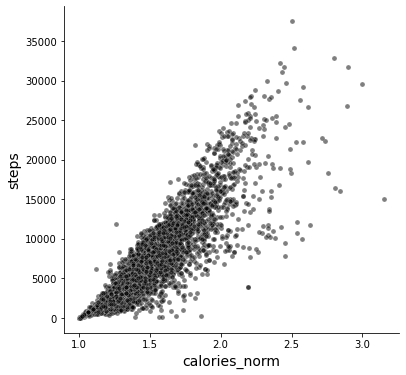

In [13]:
plot_scatter(filter_df(act,"sedentary_minutes",1400,gt=False),"calories_norm","steps",square=False)

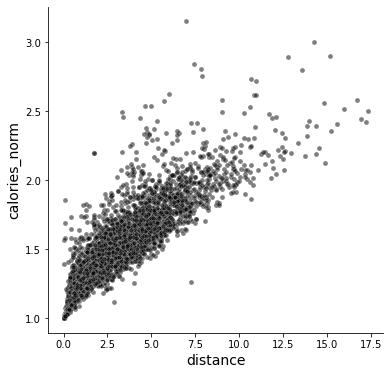

In [14]:
plot_scatter(filter_df(act,"sedentary_minutes",1400,gt=False),"distance","calories_norm",square=False)

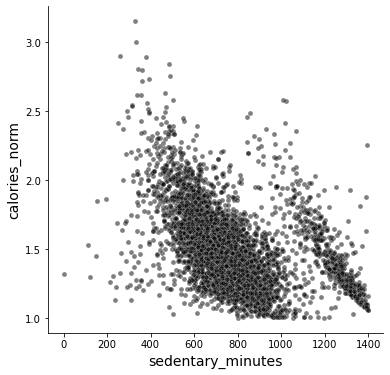

In [15]:
plot_scatter(filter_df(act,"sedentary_minutes",1400,gt=False),"sedentary_minutes","calories_norm",square=False)

### Analyzing with MIC

In [16]:
for var_pair in [["steps","calories_norm"],["distance","calories_norm"],["sedentary_minutes","calories_norm"]]:
    temp = filter_df(act,"sedentary_minutes",1400,gt=False)
    mic_score_act = get_mic(temp,var_pair[0],var_pair[1])
    _,_,r2_act = compute_linear_regression(temp.dropna(),var_pair[0],var_pair[1])
    print(f"Param1:\t{var_pair[0]}\nParam2\t{var_pair[1]}")
    print(f"MIC:\t{round(mic_score_act,4)}\nOLS:\t{round(r2_act,4)}\n")

Param1:	steps
Param2	calories_norm
MIC:	0.6751
OLS:	0.7799

Param1:	distance
Param2	calories_norm
MIC:	0.6612
OLS:	0.7617

Param1:	sedentary_minutes
Param2	calories_norm
MIC:	0.2683
OLS:	0.1968



<div class="alert alert-block alert-warning">
 
MIC performed as well as OLS although some of the relationships look less linear than in the previous analysis. I would have hoped that it would have picked up on the logarithmic look of the `calories_norm` vs `distance`. 
    
</div>